In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [4]:
def seed_everything(random_state=0):
    """
    Fix randomness for deterministic results
    :param random_state: random state generating random numbers
    :return: None
    """

    np.random.seed(random_state)
    _ = torch.manual_seed(random_state)
    torch.cuda.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
random_state = 0
seed_everything(random_state)

In [6]:
df = pd.read_excel('/home/hyungyu/survival_analysis/paper_ex/new_data_0818.xlsx')
df = df.drop(columns=['Unnamed: 0','D_date','pic_date'])

In [1]:
# df = df.sample(100)
# df

In [8]:
print((df['event']==0).sum(), (df['event']==1).sum())

748 210


# Pytorch Dataset 정의

In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [10]:
class BedsoreDataset(Dataset):
    def __init__(self, file_list, labels, transforms = None):
        super().__init__()
        self.file_list = file_list
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, ix):
        filename = self.file_list[ix]
        img = Image.open(filename).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
        label = torch.from_numpy(self.labels[ix])
        return img, label

# Image Tranforms

In [11]:
import torchvision.transforms as T

In [12]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(size, scale = (0.5, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness= 0.3, contrast= 0.3),
        T.RandomAffine(degrees = 20, translate= (0.1, 0.1), shear = (-10, 10)),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
    'test': T.Compose([
        T.Resize(256),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
}

In [13]:
def get_data_from_ds(ds):
    x_test = []
    y_test = []

    for x, y in ds:
        x_test.append(x.numpy())
        if isinstance(y, tuple):
            y = torch.stack(y)
        y_test.append(y.numpy())

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    durations_test, events_test = y_test.T

    return x_test, durations_test, events_test

# Pretrained Models

In [14]:
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

In [15]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

In [16]:
class resnet50(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50 = models.resnet50(pretrained = True)
        del resnet50.fc
        
        for params in resnet50.parameters():
            params.requires_grad = False
            
        self.feature = nn.Sequential(*list(resnet50.children()))
        self.Flatten = nn.Sequential(nn.Flatten()).to(device)
        
    def forward(self, input):
        feats = self.feature(input)
        feats = self.Flatten(feats)
        
        return feats
        

In [17]:
net = resnet50()
net.to(device)
# net = nn.DataParallel(net).to(device)
pass

In [18]:
# from torchsummary import summary
# summary(net, (3,224,224))

# test

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [20]:
n_folds = 5
skf = StratifiedKFold(n_splits = 5)

file_list = df['file_path'].values
label_list = df[['duration', 'event']].values

# CoxPH

In [ ]:
from sklearn.decomposition import PCA
from lifelines import CoxPHFitter

c_index_train = []
std_train = []

c_index_test = []
std_test = []

for i, (train_idx, test_idx) in enumerate(skf.split(file_list, label_list[:,1])):
    print("="*40)
    print("="*40)
    print(f'Fold {i+1} of {n_folds}')
    
    train_idx, val_idx = train_test_split(train_idx)
    
    train_file_list, train_labels = file_list[train_idx], label_list[train_idx]
    val_file_list, val_labels = file_list[val_idx], label_list[val_idx]
    test_file_list, test_labels = file_list[test_idx], label_list[test_idx]
    print(f'( Train : {len(train_file_list)} ) Survive : {np.count_nonzero(train_labels[:,1] == 0)}명 / {np.around(np.mean(train_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(train_labels[:,1] ==1)}명 / {np.around( np.mean(train_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Val : {len(val_file_list)} ) Survive : {np.count_nonzero(val_labels[:,1] == 0)}명 / {np.around(np.mean(val_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(val_labels[:,1] ==1)}명 / {np.around( np.mean(val_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Test : {len(test_file_list)} ) Survive : {np.count_nonzero(test_labels[:,1] == 0)}명 / {np.around(np.mean(test_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(test_labels[:,1] ==1)}명 / {np.around( np.mean(test_labels[:,1] == 1)*100, 3 )}% ')
    
    train_df = pd.DataFrame({'file_path': train_file_list, 'duration': train_labels[:,0], 'event': train_labels[:,1]})
    val_df = pd.DataFrame({'file_path': val_file_list, 'duration': val_labels[:,0], 'event': val_labels[:,1]})
    test_df = pd.DataFrame({'file_path': test_file_list, 'duration': test_labels[:,0], 'event': test_labels[:,1]})

    train_ds = BedsoreDataset(train_file_list, train_labels, transforms=transforms['train'])
    val_ds   = BedsoreDataset(val_file_list, val_labels, transforms=transforms['test'])
    test_ds  = BedsoreDataset(test_file_list, test_labels, transforms=transforms['test'])
    
    # test_dl = DataLoader(test_ds, batch_size=256, shuffle = False)
    x_train, duration_train, events_train = get_data_from_ds(train_ds)
    x_test, duration_test, events_test = get_data_from_ds(test_ds)
    
    net.eval()
    # feats = net(torch.Tensor(x_test).to(device))
    with torch.no_grad():
        feature_train = net(torch.Tensor(x_train).to(device))
        feature_train = feature_train.cpu().numpy()
        
        feature_test = net(torch.Tensor(x_test).to(device))
        feature_test = feature_test.cpu().numpy()
    
    pca = PCA(n_components=0.9)  
    pca.fit(feature_train)
    
    
    x_train_pca = pca.transform(feature_train)
    phi_train = {f'pca{num+1}':x_train_pca[:,num] for num in range(x_train_pca.shape[1])}
    
    pca_train_df = pd.DataFrame(phi_train)
    pca_train_df['duration'] = duration_train
    pca_train_df['event'] = events_train
    
    
    x_test_pca = pca.transform(feature_test)
    phi_test = {f'pca{num+1}':x_test_pca[:,num] for num in range(x_test_pca.shape[1])}
    pca_test_df = pd.DataFrame(phi_test)
    pca_test_df['duration'] = duration_test
    pca_test_df['event'] = events_test
    
    
    cph = CoxPHFitter(penalizer = 0.001)
    cph.fit(pca_train_df, duration_col='duration', event_col='event')
    c_index_train.append(cph.score(pca_train_df, scoring_method="concordance_index"))
    # cph.print_summary()
    
    print("===============================================")
    print("===============================================")
    print("test_c_index : ",cph.score(pca_test_df, scoring_method= "concordance_index") )
    c_index_test.append(cph.score(pca_test_df, scoring_method= "concordance_index"))

print("===============================================")
print("===============================================")
average_c_index_train = np.mean(c_index_train)
std_c_index_train = np.std(c_index_train)
print(f"Average C-index_Train): {average_c_index_train}")
print(f"Std of C-index_Train : {std_c_index_train}")


average_c_index_test = np.mean(c_index_test)
std_c_index_test = np.std(c_index_test)
print(f"Average C-index_Test): {average_c_index_test}")
print(f"Std of C-index_Test : {std_c_index_test}")

In [22]:
hazard_score = cph.predict_log_partial_hazard(pca_test_df)
bounds = np.percentile(hazard_score,[33.333, 66.666])

In [ ]:
bounds

In [ ]:
hazard_score

In [2]:
a = cph.predict_survival_function(pca_test_df)
test2 = a.T
# test2
# bounds = np.percentile(a[-1], [33.333, 66.666])

test2['duration'] = duration_test
test2['event'] = events_test
test2['group'] = np.where(hazard_score<bounds[0],0,np.where(hazard_score<bounds[1],1,2))
# test2

p-value (low vs mid): 0.4772652422
np-value (low vs high): 0.0163412201
np-value (mid vs high): 0.0774057169


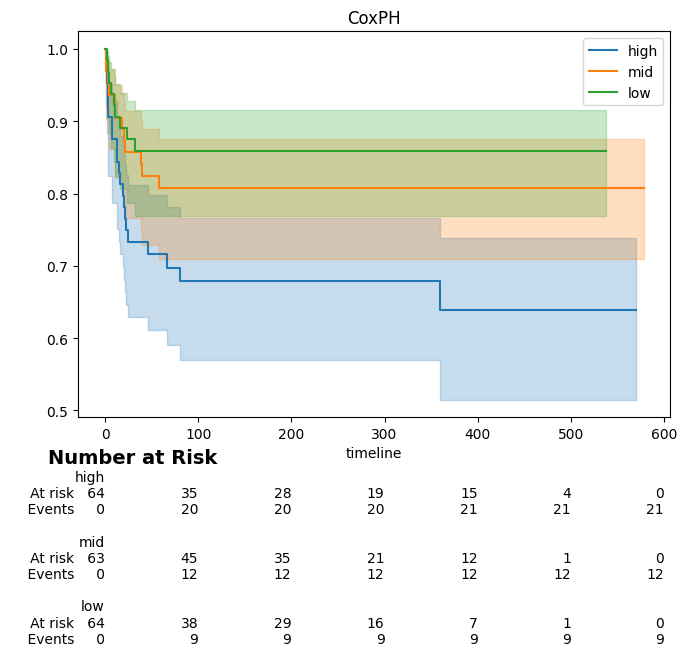

In [30]:
from lifelines.statistics import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

low_g = test2.loc[test2['group'] == 0]
middle_g = test2.loc[test2['group'] == 1]
high_g = test2.loc[test2['group'] == 2]

result12 = logrank_test(low_g['duration'], middle_g['duration'], low_g['event'], middle_g['event'])
result13 = logrank_test(low_g['duration'], high_g['duration'], low_g['event'], high_g['event'])
result23 = logrank_test(middle_g['duration'], high_g['duration'], middle_g['event'], high_g['event'])

p_value12 = format(result12.p_value,'.10f')
p_value13 = format(result13.p_value,'.10f')
p_value23 = format(result23.p_value,'.10f')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)

kmf_high = KaplanMeierFitter(alpha = 0.1)
ax = kmf_high.fit(test2.loc[test2['group'] == 2]['duration'], test2.loc[test2['group'] == 2]['event'], label='high').plot_survival_function(ax=ax)

kmf_mid = KaplanMeierFitter(alpha = 0.1)
ax = kmf_mid.fit(test2.loc[test2['group'] == 1]['duration'], test2.loc[test2['group'] == 1]['event'], label='mid').plot_survival_function(ax=ax)

kmf_low = KaplanMeierFitter(alpha = 0.1)
ax = kmf_low.fit(test2.loc[test2['group'] == 0]['duration'], test2.loc[test2['group'] == 0]['event'], label='low').plot_survival_function(ax=ax)

add_at_risk_counts(kmf_high, kmf_mid, kmf_low, rows_to_show = ['At risk','Events'], ax=ax)

ax.text(-0.05, -0.12, 'Number at Risk', fontsize=14, fontweight='bold', transform=ax.transAxes)

# p-value 값을 표시하려는 위치 지정
text_position_x = 300
text_position_y = 0.52

# p-value 결과에 대한 텍스트
print(f'p-value (low vs mid): {p_value12}')
print(f'np-value (low vs high): {p_value13}')
print(f'np-value (mid vs high): {p_value23}')
# p_value_text = f"p-value (low vs mid): {p_value12}\np-value (low vs high): {p_value13}\np-value (mid vs high): {p_value23}"

# ax.text(text_position_x, text_position_y, p_value_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.title('CoxPH')
plt.tight_layout()

In [ ]:
hazard_score2 = cph.predict_cumulative_hazard(pca_test_df)
hazard_rate = np.exp(-hazard_score2).iloc[-1]
bounds2 = np.percentile(hazard_rate,[33.333, 66.666])
bounds2

In [ ]:
hazard_rate

In [3]:
a = cph.predict_survival_function(pca_test_df)
test3 = a.T
# test3
# bounds = np.percentile(a[-1], [33.333, 66.666])

test3['duration'] = duration_test
test3['event'] = events_test
test3['group'] = np.where(hazard_rate<bounds2[0],0,np.where(hazard_rate<bounds2[1],1,2))
# test3

p-value (low vs mid): 0.4772652422
np-value (low vs high): 0.0163412201
np-value (mid vs high): 0.0774057169


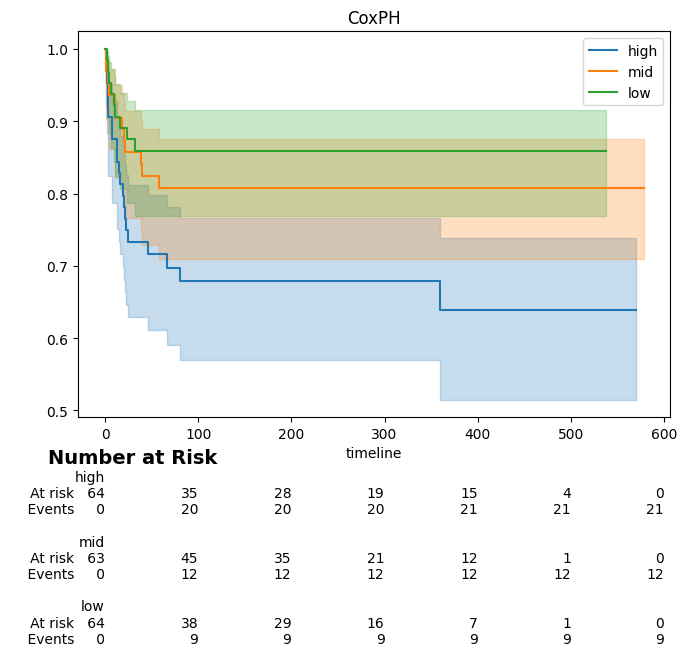

In [34]:
from lifelines.statistics import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

low_g = test3.loc[test3['group'] == 2]
middle_g = test3.loc[test3['group'] == 1]
high_g = test3.loc[test3['group'] == 0]

result12 = logrank_test(low_g['duration'], middle_g['duration'], low_g['event'], middle_g['event'])
result13 = logrank_test(low_g['duration'], high_g['duration'], low_g['event'], high_g['event'])
result23 = logrank_test(middle_g['duration'], high_g['duration'], middle_g['event'], high_g['event'])

p_value12 = format(result12.p_value,'.10f')
p_value13 = format(result13.p_value,'.10f')
p_value23 = format(result23.p_value,'.10f')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)

kmf_high = KaplanMeierFitter(alpha = 0.1)
ax = kmf_high.fit(test3.loc[test3['group'] == 0]['duration'], test3.loc[test3['group'] == 0]['event'], label='high').plot_survival_function(ax=ax)

kmf_mid = KaplanMeierFitter(alpha = 0.1)
ax = kmf_mid.fit(test3.loc[test3['group'] == 1]['duration'], test3.loc[test3['group'] == 1]['event'], label='mid').plot_survival_function(ax=ax)

kmf_low = KaplanMeierFitter(alpha = 0.1)
ax = kmf_low.fit(test3.loc[test3['group'] == 2]['duration'], test3.loc[test3['group'] == 2]['event'], label='low').plot_survival_function(ax=ax)

add_at_risk_counts(kmf_high, kmf_mid, kmf_low, rows_to_show = ['At risk','Events'], ax=ax)

ax.text(-0.05, -0.12, 'Number at Risk', fontsize=14, fontweight='bold', transform=ax.transAxes)

# p-value 값을 표시하려는 위치 지정
text_position_x = 300
text_position_y = 0.52

# p-value 결과에 대한 텍스트
print(f'p-value (low vs mid): {p_value12}')
print(f'np-value (low vs high): {p_value13}')
print(f'np-value (mid vs high): {p_value23}')
# p_value_text = f"p-value (low vs mid): {p_value12}\np-value (low vs high): {p_value13}\np-value (mid vs high): {p_value23}"

# ax.text(text_position_x, text_position_y, p_value_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.title('CoxPH')
plt.tight_layout()

# Piecewise Exponential

In [23]:
from lifelines import PiecewiseExponentialRegressionFitter

In [ ]:
from sklearn.decomposition import PCA
from lifelines import PiecewiseExponentialFitter
from lifelines.utils import concordance_index
from lifelines import PiecewiseExponentialRegressionFitter

c_index_train = []
std_train = []

c_index_test = []
std_test = []

for i, (train_idx, test_idx) in enumerate(skf.split(file_list, label_list[:,1])):
    print("="*40)
    print("="*40)
    print(f'Fold {i+1} of {n_folds}')
    
    train_idx, val_idx = train_test_split(train_idx)
    
    train_file_list, train_labels = file_list[train_idx], label_list[train_idx]
    val_file_list, val_labels = file_list[val_idx], label_list[val_idx]
    test_file_list, test_labels = file_list[test_idx], label_list[test_idx]
    print(f'( Train : {len(train_file_list)} ) Survive : {np.count_nonzero(train_labels[:,1] == 0)}명 / {np.around(np.mean(train_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(train_labels[:,1] ==1)}명 / {np.around( np.mean(train_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Val : {len(val_file_list)} ) Survive : {np.count_nonzero(val_labels[:,1] == 0)}명 / {np.around(np.mean(val_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(val_labels[:,1] ==1)}명 / {np.around( np.mean(val_labels[:,1] == 1)*100, 3 )}% ')
    print(f'( Test : {len(test_file_list)} ) Survive : {np.count_nonzero(test_labels[:,1] == 0)}명 / {np.around(np.mean(test_labels[:,1] == 0)*100 , 3)}% , Dead : {np.count_nonzero(test_labels[:,1] ==1)}명 / {np.around( np.mean(test_labels[:,1] == 1)*100, 3 )}% ')
    
    train_ds = BedsoreDataset(train_file_list, train_labels, transforms=transforms['train'])
    val_ds   = BedsoreDataset(val_file_list, val_labels, transforms=transforms['test'])
    test_ds  = BedsoreDataset(test_file_list, test_labels, transforms=transforms['test'])
    
    # test_dl = DataLoader(test_ds, batch_size=256, shuffle = False)
    x_train, duration_train, events_train = get_data_from_ds(train_ds)
    x_test, durations_test, events_test = get_data_from_ds(test_ds)
    
    net.eval()
    # feats = net(torch.Tensor(x_test).to(device))
    with torch.no_grad():
        feature_train = net(torch.Tensor(x_train).to(device))
        feature_train = feature_train.cpu().numpy()
        
        feature_test = net(torch.Tensor(x_test).to(device))
        feature_test = feature_test.cpu().numpy()
    # pca = PCA(n_components=3)
    pca = PCA(n_components=0.9)  
    pca.fit(feature_train)
    
    x_train_pca = pca.transform(feature_train)
    phi_train = {f'pca{num+1}':x_train_pca[:,num] for num in range(x_train_pca.shape[1])}

    pca_train_df = pd.DataFrame(phi_train)
    pca_train_df['duration'] = duration_train / 100
    pca_train_df['event'] = events_train

    
    x_test_pca = pca.transform(feature_test)
    phi_test = {f'pca{num+1}':x_test_pca[:,num] for num in range(x_test_pca.shape[1])}
    pca_test_df = pd.DataFrame(phi_test)
    pca_test_df['duration'] = durations_test / 100
    pca_test_df['event'] = events_test
    
    
    mini = min(duration_train/100)
    maxi = max(duration_train/100)
    print(f"mini : {mini}, maxi : {maxi}")
    a= np.linspace(mini, maxi, 6)
    time_interval = a[1:5]
    epsilon = 1e-6
    pca_train_df['duration'] = pca_train_df['duration'].apply(lambda x: x if x > 0 else x + epsilon)
    
    # pc_hazard_fiiter = PiecewiseExponentialFitter(breakpoints=[115.6, 231.2, 346.8, 462.4])
    # PW_Exp = PiecewiseExponentialFitter(breakpoints = time_interval)
    PW_Exp = PiecewiseExponentialRegressionFitter(breakpoints = time_interval, alpha = 0.05, penalizer = 0.001)
    PW_Exp.fit(df = pca_train_df, duration_col = 'duration', event_col = 'event',show_progress=True)
    c_index_train.append(PW_Exp.score(pca_train_df, scoring_method="concordance_index"))
    # PW_Exp.print_summary()
    print("test_c_index : ",PW_Exp.score(pca_test_df, scoring_method= "concordance_index") )
    c_index_test.append(PW_Exp.score(df = pca_test_df, scoring_method="concordance_index"))
    
    # c_index_val = concordance_index(df_test_t["duration"], -predict_partial_hazard(df_test_t[["pca"]]), df_test_t["event"])
    # pc_hazard_fiiter.fit(df_test_t, duration_col='duration', event_col='event')
    # c_index.append(pc_hazard_fiiter.score(df_test_t, scoring_method="concordance_index"))
    
    
print("===============================================")
print("===============================================")
average_c_index_train = np.mean(c_index_train)
std_c_index_train = np.std(c_index_train)
print(f"Average C-index_Train): {average_c_index_train}")
print(f"Std of C-index_Train : {std_c_index_train}")


average_c_index_test = np.mean(c_index_test)
std_c_index_test = np.std(c_index_test)
print(f"Average C-index_Test): {average_c_index_test}")
print(f"Std of C-index_Test : {std_c_index_test}")

In [23]:
a= PW_Exp.predict_cumulative_hazard(pca_test_df)
surv_rate = np.exp(-a).iloc[-1]

In [ ]:
surv_rate

In [ ]:
bounds = np.percentile(surv_rate,[33.333, 66.666])
bounds

In [4]:
surv = PW_Exp.predict_survival_function(pca_test_df)
test = surv.T
test['duration'] = durations_test
test['event'] = events_test
test['group'] = np.where(surv_rate.T<bounds[0],0,np.where(surv_rate.T<bounds[1],1,2))
# test

p-value (low vs mid): 0.0344593296
p-value (low vs high): 0.0094048779
p-value (mid vs high): 0.6590577048


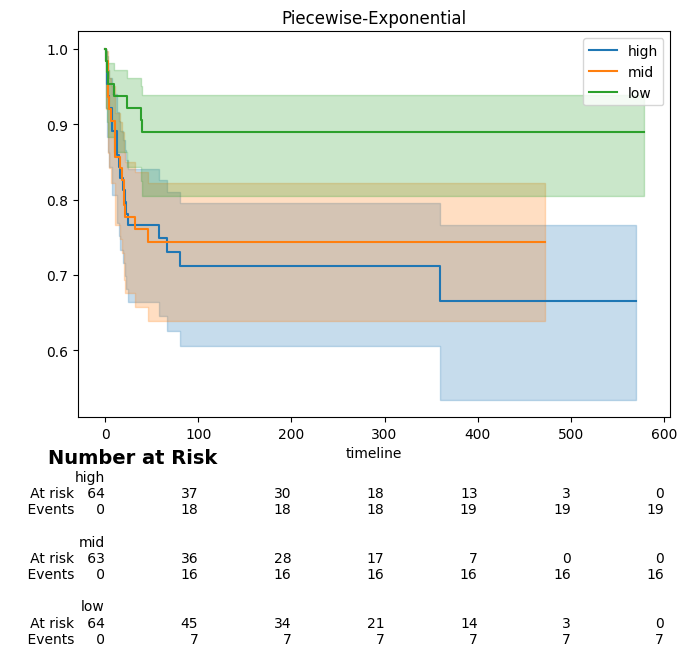

In [30]:
from lifelines.statistics import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

low_g = test.loc[test['group'] == 2] # 생존확률이 낮을 수록 고위험군이니까 low -> high
middle_g = test.loc[test['group'] == 1]
high_g = test.loc[test['group'] == 0]

result12 = logrank_test(low_g['duration'], middle_g['duration'], low_g['event'], middle_g['event'])
result13 = logrank_test(low_g['duration'], high_g['duration'], low_g['event'], high_g['event'])
result23 = logrank_test(middle_g['duration'], high_g['duration'], middle_g['event'], high_g['event'])

p_value12 = format(result12.p_value,'.10f')
p_value13 = format(result13.p_value,'.10f')
p_value23 = format(result23.p_value,'.10f')

plt.figure(figsize=(7,7))
ax = plt.subplot(111)

kmf_high = KaplanMeierFitter(alpha = 0.1)
ax = kmf_high.fit(test.loc[test['group'] == 0]['duration'], test.loc[test['group'] == 0]['event'], label='high').plot_survival_function(ax=ax)

kmf_mid = KaplanMeierFitter(alpha = 0.1)
ax = kmf_mid.fit(test.loc[test['group'] == 1]['duration'], test.loc[test['group'] == 1]['event'], label='mid').plot_survival_function(ax=ax)

kmf_low = KaplanMeierFitter(alpha = 0.1)
ax = kmf_low.fit(test.loc[test['group'] == 2]['duration'], test.loc[test['group'] == 2]['event'], label='low').plot_survival_function(ax=ax)

add_at_risk_counts(kmf_high, kmf_mid, kmf_low, rows_to_show = ['At risk','Events'], ax=ax)

ax.text(-0.05, -0.12, 'Number at Risk', fontsize=14, fontweight='bold', transform=ax.transAxes)

# p-value 값을 표시하려는 위치 지정
text_position_x = 300
text_position_y = 0.6

# p-value 결과에 대한 텍스트
print(f'p-value (low vs mid): {p_value12}')
print(f'p-value (low vs high): {p_value13}')
print(f'p-value (mid vs high): {p_value23}')
# p_value_text = f"p-value (low vs mid): {p_value12}\np-value (low vs high): {p_value13}\np-value (mid vs high): {p_value23}"

# ax.text(text_position_x, text_position_y, p_value_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
plt.title('Piecewise-Exponential')
plt.tight_layout()